# Libraries

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomFlip, RandomRotation,Resizing,Rescaling,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization,Input,RandomZoom
from keras.callbacks import CSVLogger,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import TopKCategoricalAccuracy,Precision,Recall,AUC
from keras.losses import CategoricalCrossentropy
from keras.layers import LeakyReLU,ReLU,ELU
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_score,recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [2]:
SEED = 99 
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

#### Checking if the GPU is available 

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading and preparing the Dataset

In [4]:
train_directory = "TRAINPATH"
val_directory = "TESTPATH"
CLASSES = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_directory,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASSES,
        color_mode='grayscale', 
        batch_size= 32, 
        image_size=(48,48), 
        shuffle=True, 
        seed=SEED,
    )

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            val_directory,
            labels='inferred',
            label_mode='categorical',
            class_names=CLASSES,
            color_mode='grayscale',
            batch_size=32,
            image_size=(48,48),
            shuffle=True,
            seed=SEED,
    )


Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.


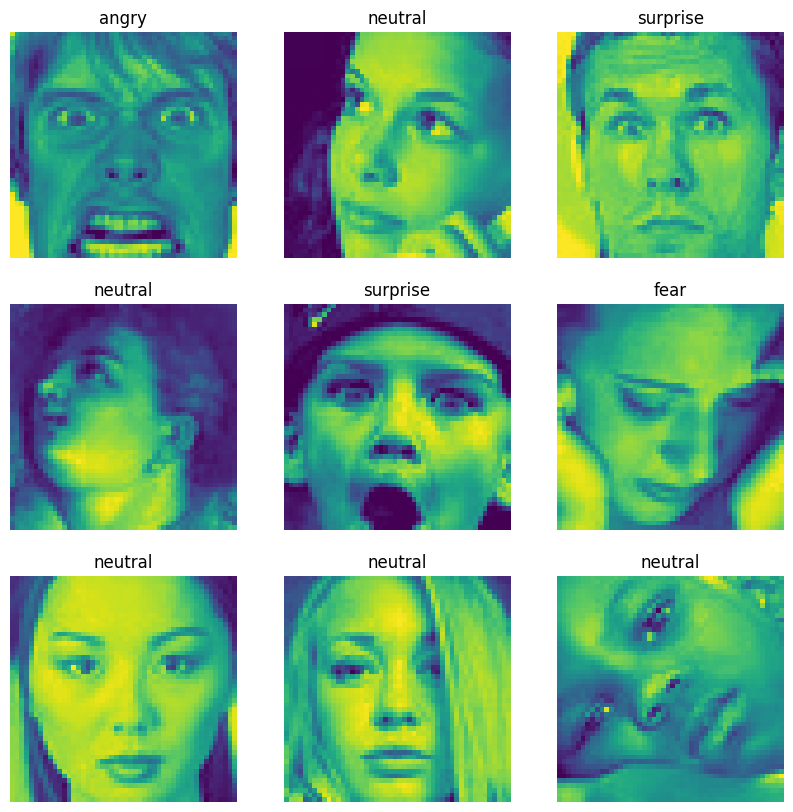

In [6]:
for image, label in training_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(CLASSES[tf.argmax(label[i]).numpy()])
        plt.axis("off")

## Data Augmentation

In [7]:
def create_augmentation_layer():
       return tf.keras.Sequential([
           RandomFlip('horizontal'), 
           RandomRotation(factor=(-0.1, 0.1)), 
])

In [8]:
augmentation_layer = create_augmentation_layer()
training_dataset = training_dataset.map(
       lambda x, y: (augmentation_layer(x, training=True), y),
       num_parallel_calls=tf.data.AUTOTUNE
   )
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

## Resize And Rescale Layer

#### The importance of this layer is because we are going to train our model based on 48x48x1 images and we are going to apply 1/255.
#### normalization to this model so we are going to need a layer that automatically transforms data into this format before model to predict

In [9]:
resize_and_rescale_layer = tf.keras.Sequential([
    Resizing(48, 48),
    Rescaling(1./255)
])

## Callbacks

In [10]:
callbacks = []
callbacks.append(CSVLogger(f'final_cnn_logs/cnn_final_99_seed.csv'))
callbacks.append(ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=6, min_lr=1e-5,verbose=1))
callbacks.append(EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)) 

model_dir = 'saved_models'
checkpoint_path = os.path.join(model_dir, 'best_emotion_model_99_seed.h5')
callbacks.append(ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,     
    mode='max',              
    verbose=1                
))


## CNN Model

In [11]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(None, None, 1)))
cnn_model.add(resize_and_rescale_layer)
        
        # First block
cnn_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', ))
cnn_model.add(LeakyReLU())
cnn_model.add(Conv2D(64, kernel_size=(3, 3),  padding='same'))
cnn_model.add(LeakyReLU())
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))
        
        # Second block
cnn_model.add(Conv2D(128, kernel_size=(5, 5),  padding='same'))
cnn_model.add(LeakyReLU())
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))
        
        # Third block
cnn_model.add(Conv2D(512, kernel_size=(3, 3),  padding='same'))
cnn_model.add(LeakyReLU())
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))
        
        # Fourth block
cnn_model.add(Conv2D(512, kernel_size=(3, 3),  padding='same'))
cnn_model.add(LeakyReLU())
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))
        
        # Dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(256, ))
cnn_model.add(LeakyReLU())
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
        
cnn_model.add(Dense(512, ))
cnn_model.add(LeakyReLU())
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
        
cnn_model.add(Dense(6, activation='softmax'))

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                      

## Compile the Model

In [12]:
cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_k_accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')],)

## Fit and Train

In [ ]:
history = cnn_model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=40,
        callbacks=callbacks,
        verbose=1
)

Epoch 1/40
884/884 [==============================] - ETA: 0s - loss: 1.7815 - accuracy: 0.3085 - top_k_accuracy: 0.5049 - top_2_accuracy: 0.5049 - precision: 0.4290 - recall: 0.1200 - auc: 0.6589
Epoch 1: val_accuracy improved from -inf to 0.43470, saving model to saved_models\best_emotion_model_99_seed.h5
884/884 [==============================] - 52s 49ms/step - loss: 1.7815 - accuracy: 0.3085 - top_k_accuracy: 0.5049 - top_2_accuracy: 0.5049 - precision: 0.4290 - recall: 0.1200 - auc: 0.6589 - val_loss: 1.4410 - val_accuracy: 0.4347 - val_top_k_accuracy: 0.6249 - val_top_2_accuracy: 0.6249 - val_precision: 0.6705 - val_recall: 0.2479 - val_auc: 0.7780 - lr: 0.0010
Epoch 2/40
720/884 [=======================>......] - ETA: 5s - loss: 1.4629 - accuracy: 0.4283 - top_k_accuracy: 0.6323 - top_2_accuracy: 0.6323 - precision: 0.6217 - recall: 0.2279 - auc: 0.7717

## Extract Log Datas For Visualisation

In [35]:
path = "final_cnn_logs"

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

csv_datas = []

for file in csv_files:
    full_path = os.path.join(path,file)
    df = pd.read_csv(full_path)
    csv_datas.append((file,df))

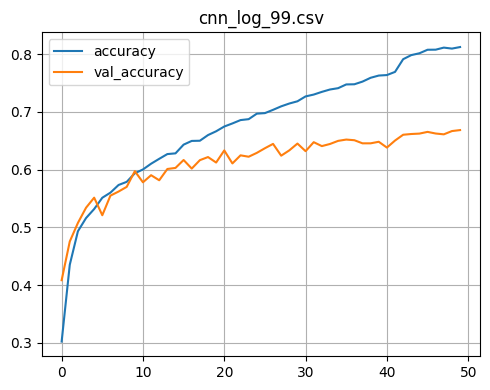

In [36]:
def visualize_model_results(csv_datas,train_metric='accuracy',val_metric='val_accuracy'):
    # Calculate the number of rows and columns for subplots
    n_plots = len(csv_datas)
    n_cols = min(3, n_plots)  # Maximum 3 plots per row
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Flatten axes array for easier indexing
    if n_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each model's results
    for idx, (file, df) in enumerate(csv_datas):
        ax = axes[idx]
        ax.plot(df[train_metric], label=train_metric)
        ax.plot(df[val_metric], label=val_metric)
        ax.set_title(f'{file}')
        ax.legend()
        ax.grid(True)
    
    # Hide empty subplots if any
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show() 
visualize_model_results(csv_datas,train_metric='accuracy',val_metric='val_accuracy')

In [60]:
def top_performance(csv_datas):
    keys = ['val_accuracy','val_auc','val_loss','val_precision','val_recall','val_top_k_accuracy']
    top_performance = {}

    for key in keys:
        best_value = float('inf') if key == 'val_loss' else -float('inf')
        best_file = None
        metric_found = False

        for file, data in csv_datas:
            if key in data.columns:
                metric_found = True
                if key == 'val_loss':
                    current_value = data[key].min()
                    if current_value < best_value:
                        best_value = current_value
                        best_file = file
                else:
                    current_value = data[key].max()
                    if current_value > best_value:
                        best_value = current_value
                        best_file = file

        if metric_found:
            top_performance[key] = {best_file: best_value}
        else:
            top_performance[key] = {"No data available": None}

    return top_performance 
top_performance(csv_datas)

{'val_accuracy': {'cnn_log_99.csv': 0.6684590578079224},
 'val_auc': {'cnn_log_99_seed.csv': 0.9131696224212646},
 'val_loss': {'cnn_log_factor_02_zoom_no.csv': 0.9890933632850648},
 'val_precision': {'cnn_log_42_seed.csv': 0.7208390831947327},
 'val_recall': {'cnn_log_42_seed.csv': 0.6350643634796143},
 'val_top_k_accuracy': {'cnn_log_99.csv': 0.8361397981643677}}

## Evaluating The Model

In [19]:
final_model = load_model('saved_models/best_emotion_model.h5')

In [20]:
results = final_model.evaluate(validation_dataset)
print("Evaluation Results:")
for name, value in zip(final_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

221/221 [==============================] - 3s 9ms/step - loss: 1.1347 - accuracy: 0.6661 - top_k_accuracy: 0.8312 - top_2_accuracy: 0.8312 - precision: 0.7014 - recall: 0.6348 - auc: 0.9085
Evaluation Results:
loss: 1.1347
accuracy: 0.6661
top_k_accuracy: 0.8312
top_2_accuracy: 0.8312
precision: 0.7014
recall: 0.6348
auc: 0.9085


1/1 [==============================] - 0s 103ms/step


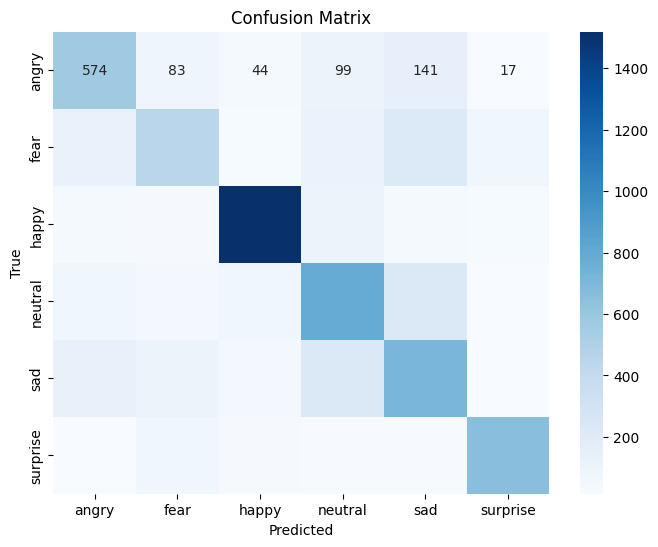

In [25]:
true_labels = []
pred_labels = []

for images, labels in validation_dataset:
    preds = final_model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(true_labels, pred_labels)
['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 22ms/step


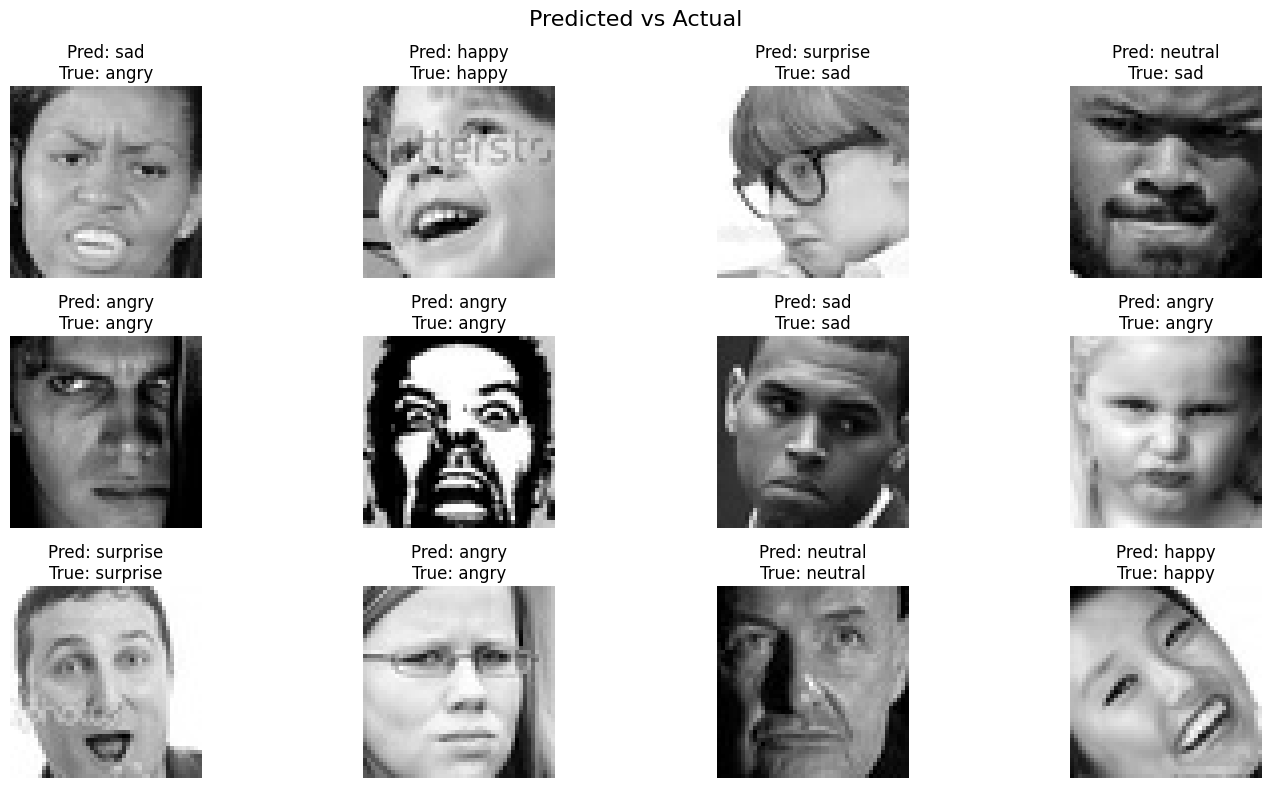

In [28]:
for images, labels in validation_dataset.take(1):
    # Model tahmini
    preds = final_model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)

    # Plot
    plt.figure(figsize=(15, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Pred: {CLASSES[pred_labels[i]]}\nTrue: {CLASSES[true_labels[i]]}")
        plt.axis('off')
    plt.suptitle("Predicted vs Actual", fontsize=16)
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 29ms/step


c:\conda_envs\tf\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


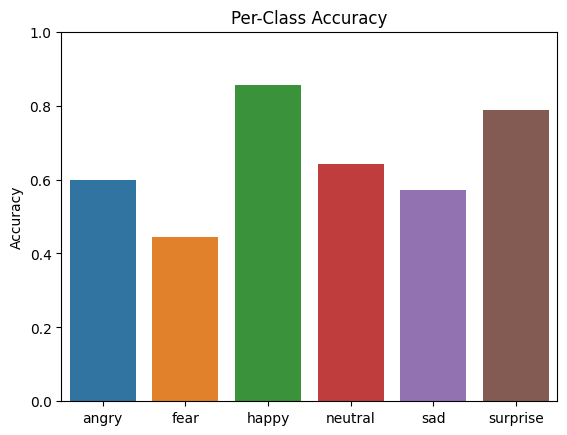

In [30]:
y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = final_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))              # Modelin tahmini
    y_true.extend(np.argmax(labels.numpy(), axis=1))  
    
conf_mat = confusion_matrix(y_true, y_pred)
per_class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)

sns.barplot(x=CLASSES, y=per_class_acc)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()         # Gerçek değer


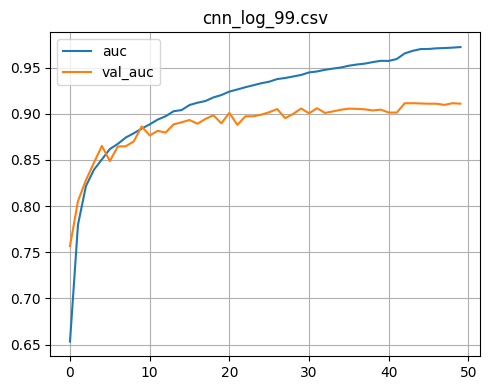

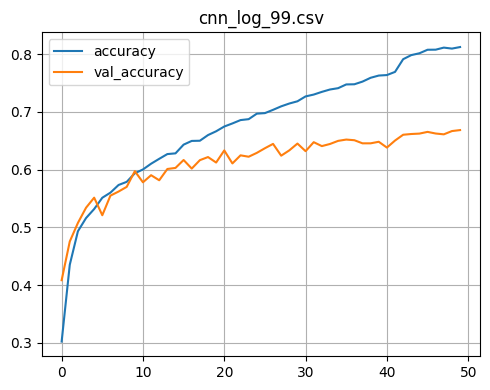

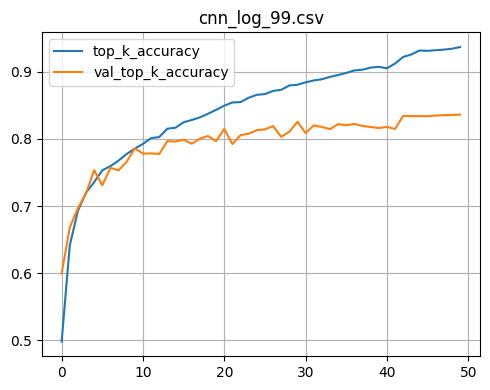

In [39]:
visualize_model_results(csv_datas,train_metric='auc',val_metric='val_auc')
visualize_model_results(csv_datas,train_metric='accuracy',val_metric='val_accuracy')
visualize_model_results(csv_datas,train_metric='top_k_accuracy',val_metric='val_top_k_accuracy')

In [43]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
print("Precision per class:", precision)
print("Recall per class:", recall)

# Macro and Micro averaged Precision and Recall
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
micro_precision = precision_score(y_true, y_pred, average='micro')
micro_recall = recall_score(y_true, y_pred, average='micro')
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)

Confusion Matrix:
 [[ 574   83   44   99  141   17]
 [ 125  454   27  118  224   76]
 [  44   35 1519  102   42   32]
 [  78   50   72  790  228   15]
 [ 132  101   52  229  714   19]
 [  20   73   34   24   24  656]]
Precision per class: [0.58992806 0.57035176 0.86899314 0.58002937 0.52002913 0.80490798]
Recall per class: [0.59916493 0.44335938 0.85625705 0.64071371 0.57257418 0.78941035]
Macro Precision: 0.6557065714466489
Macro Recall: 0.6502465969276449
Micro Precision: 0.6660534880430168
Micro Recall: 0.6660534880430168


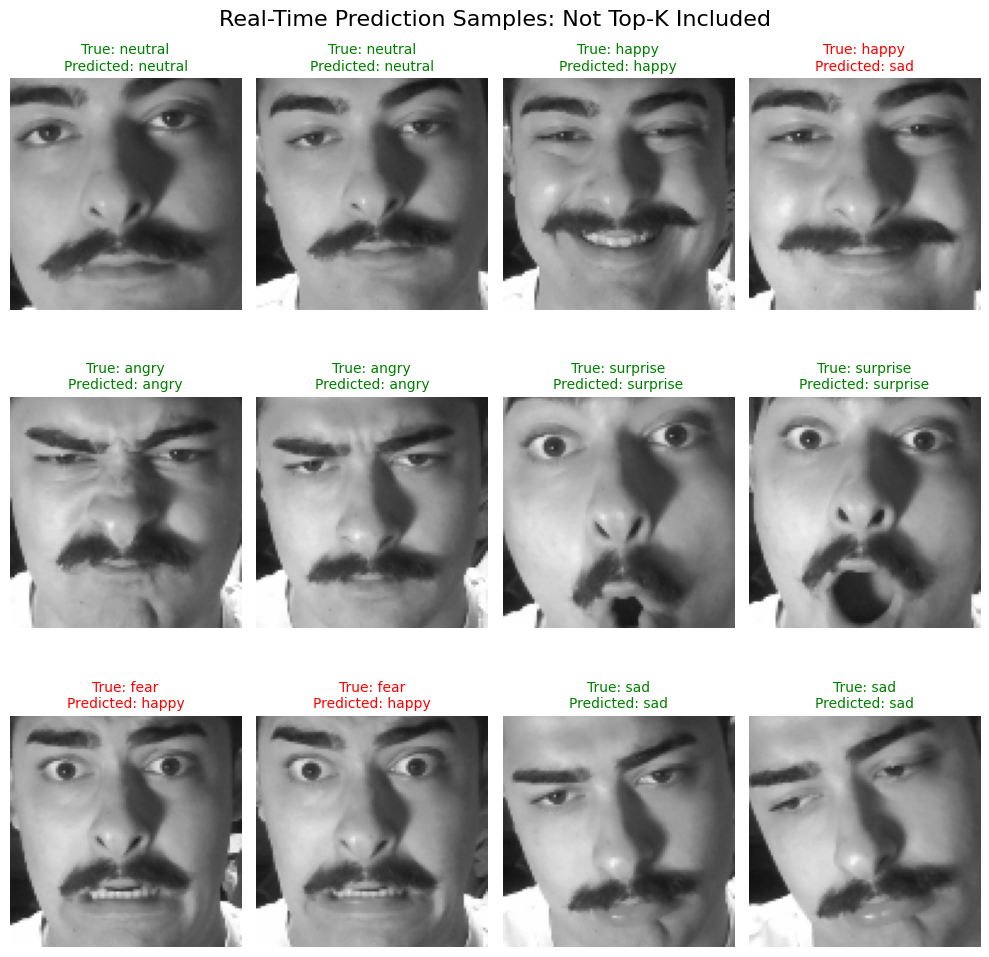

In [26]:
import os
import matplotlib.pyplot as plt
import cv2

# Klasör yolu
folder_path = 'predicted_faces'

# Klasördeki tüm dosyaları al ve en yeni 12 tanesini seç
images = sorted(os.listdir(folder_path))[-12:]

# Plot ayarları
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.flatten()

for i, filename in enumerate(images):
    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label = filename.replace(".png", "").split("_", 1)[-1]
    parts = label.split("_")

    actual = parts[1]
    predictions = parts[2:3]
    verdict = parts[-1]
    
    pred_text = "Predicted: " + ", ".join(predictions)
    title = f"True: {actual}\n{pred_text}"
    if actual in predictions:
        color = 'green'
    else:
        color = 'red'

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=10, color=color)

plt.tight_layout()
plt.suptitle("Real-Time Prediction Samples: Not Top-K Included", fontsize=16, y=1)
plt.show()
